In [1]:
import pandas as pd
import numpy as np
import sys, zipfile, os, time
import matplotlib.pyplot as plt
import glob
import datetime
import urllib3
import cdsapi
import xarray
import shutil
import warnings
import pickle
import h5py
import netCDF4
warnings.filterwarnings('ignore')

sys.path.append(os.getcwd()+'/../cds-backend/code/')
import cds_eua3 as eua

In [2]:
def get_adj(station):
    import datetime
    """Compare created adjustment to downloaded adjustment
    """
    file = ('/home/srvx11/lehre/users/a1400070/CEUAS/CEUAS/public/adjust/Temperature_adjustment/0'+station+'/feedbackglobbincorrsave0'+station+'.nc')
    data = eua.CDMDataset(file)
    
    f = open('/home/srvx11/lehre/users/a1400070/CEUAS/CEUAS/public/adjust/Temperature_adjustment/0'+station+'/found_breaks0'+station, "r")
    breaks = f.read()
    breaksfound = 0
    breakdates = []
    while breaksfound >= 0:
        breaksfound = breaks.find('break   ', breaksfound) + 1
        if breaksfound == 0:
            break
        breakdates.append(breaks[breaksfound+7:breaksfound+15])
    press = data.press[:]
    nightadj = data.rasocorr[0,:]
    dayadj = data.rasocorr[1,:]
    
    c = cdsapi.Client()
    r = c.retrieve('insitu-comprehensive-upper-air-observation-network',
                   {'variable': 'temperature',
                    'optional':['obs_minus_bg','bias_estimate','RISE_bias_estimate', 'RICH_bias_estimate', 'RASE_bias_estimate', 'RAOBCORE_bias_estimate'],
                    'statid': station,
                    'pressure_level':[10,20,30,50,70,100,150,200,250,300,400,500,700,850,925,1000]
                   }
                  )
    r.download(target='download.zip')
    assert os.stat('download.zip').st_size == r.content_length, "Downloaded file is incomplete"
    z = zipfile.ZipFile('download.zip')
    z.extractall(path='./tocompare/cds_'+station)
    z.close()
    cdsfile = glob.glob('./tocompare/cds_'+ station +'/*.nc')
    cdsdata=eua.CDMDataset(cdsfile[0]).to_dataframe()
    daydata = cdsdata[cdsdata.time.dt.hour > 6][cdsdata.time.dt.hour <= 18]
    nightdata = cdsdata[cdsdata.time.dt.hour <= 6].append(cdsdata[cdsdata.time.dt.hour > 18])
    print(str(cdsdata.time.iloc[0]))#.year)+str(cdsdata.time.iloc[0].month)+str(cdsdata.time.iloc[0].day))
    print(breakdates)
    
    breakdates.append(str(cdsdata.time.iloc[0]))#.year)+str(cdsdata.time.iloc[0].month)+str(cdsdata.time.iloc[0].day))
    dates = breakdates
    dates.reverse()
    print(dates)
    
    calc_day_out = {}
    calc_night_out = {}
    cds_day_out = {}
    cds_night_out = {}
    for i in [10,20,30,50,70,100,150,200,250,300,400,500,700,850,925,1000]:
        calc_day_out[str(i)]=[]
        calc_night_out[str(i)]=[]
        cds_day_out[str(i)]=[]
        cds_night_out[str(i)]=[]
    for i in range(len(dates)-1):
        for j in range(len(press)):
            try:
                d_adjd = dayadj[j][i]
                calc_day_out[str(int(press[j]))].append(d_adjd)
            except:
                calc_day_out[str(int(press[j]))].append(np.nan) 
            try:
                d_cdsd = daydata[daydata.plev == press[j]*100][daydata.time >= dates[i]][daydata.time < dates[i+1]]
                cds_day_out[str(int(press[j]))].append(d_cdsd.RAOBCORE_bias_estimate.iloc[0])
            except:
                cds_day_out[str(int(press[j]))].append(np.nan)
            try:
                n_cdsd = nightdata[nightdata.plev == press[j]*100][nightdata.time >= dates[i]][nightdata.time < dates[i+1]]
                cds_night_out[str(int(press[j]))].append(n_cdsd.RAOBCORE_bias_estimate.iloc[0])
            except:
                cds_night_out[str(int(press[j]))].append(np.nan)
            try:
                n_adjd = nightadj[j][i]
                calc_night_out[str(int(press[j]))].append(n_adjd)
            except:
                calc_night_out[str(int(press[j]))].append(np.nan)
                
    return dates, calc_day_out, calc_night_out, cds_day_out, cds_night_out

In [3]:
def plt_adj(dates, cdata, adata, plev, station, time, save):
    dates_list = [datetime.datetime.strptime(date, '%Y%m%d').date() for date in dates[1:]]
    fig, ax = plt.subplots()
    ax.scatter(dates_list, cdata[str(plev)], label='CDS')
    ax.scatter(dates_list, adata[str(plev)], label='Calc')

    ax.set(xlabel='breaks', ylabel='Adjustment',
           title= str(station)+' Temperature '+str(plev)+' hPa '+time)
    ax.legend()
    ax.grid()
    
    if save:
        fig.savefig(str(station)+'_Temperature_'+str(plev)+'_hPa_'+time+'.png')
    plt.show()
    return

2021-04-26 15:46:40,614 INFO Welcome to the CDS
2021-04-26 15:46:40,615 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-04-26 15:46:40,870 INFO Request is completed
2021-04-26 15:46:40,871 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1619430583.4392266-16861-7-46ce0851-f55c-451f-a96d-294334bd80dd.zip to download.zip (28.1M)
2021-04-26 15:46:43,239 INFO Download rate 11.9M/s  
2021-04-26 15:46:43,384 INFO Reading Profile on slice(None, None, None)
2021-04-26 15:46:48,792 INFO Note: NumExpr detected 56 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-04-26 15:46:48,793 INFO NumExpr defaulting to 8 threads.


1948-01-01 03:00:00
['20190203', '20111221', '20090318', '20021004', '19990902', '19970709', '19950609', '19920225', '19890628', '19840124', '19821118', '19800911', '19771201', '19750804', '19720115', '19700904', '19641218', '19630904', '19601109', '19580810', '19560802', '19550718', '19520615', '19500410']
['1948-01-01 03:00:00', '19500410', '19520615', '19550718', '19560802', '19580810', '19601109', '19630904', '19641218', '19700904', '19720115', '19750804', '19771201', '19800911', '19821118', '19840124', '19890628', '19920225', '19950609', '19970709', '19990902', '20021004', '20090318', '20111221', '20190203']


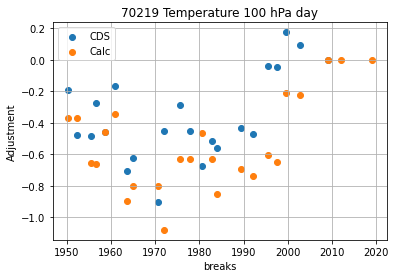

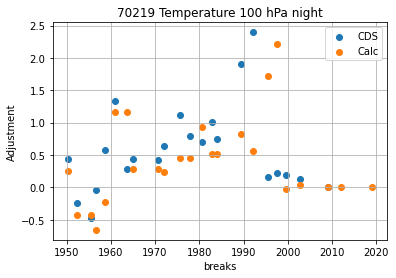

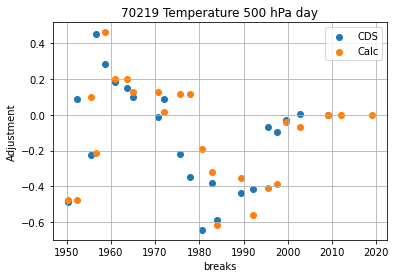

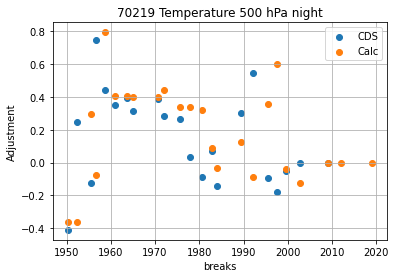

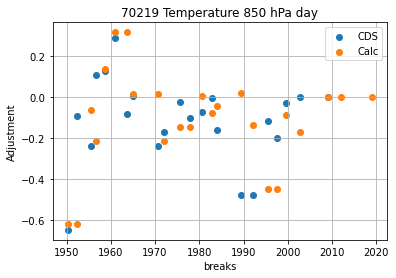

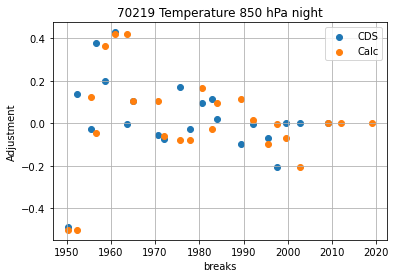

In [4]:
station = '70219'
dates, cd, cn, ad, an = get_adj(station)
plt_adj(dates, cd, ad, 100, station, 'day', save=False)
plt_adj(dates, cn, an, 100, station, 'night', save=False)
plt_adj(dates, cd, ad, 500, station, 'day', save=False)
plt_adj(dates, cn, an, 500, station, 'night', save=False)
plt_adj(dates, cd, ad, 850, station, 'day', save=False)
plt_adj(dates, cn, an, 850, station, 'night', save=False)

2021-04-26 15:48:57,828 INFO Welcome to the CDS
2021-04-26 15:48:57,829 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-04-26 15:48:58,084 INFO Request is completed
2021-04-26 15:48:58,085 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1619442520.2651842-22152-13-aa2a8e19-41a7-483e-989b-4b5c889b4b2b.zip to download.zip (30.7M)
2021-04-26 15:48:59,465 INFO Download rate 22.3M/s  
2021-04-26 15:48:59,577 INFO Reading Profile on slice(None, None, None)


1948-12-11 03:00:00
['20180920', '20141110', '20120925', '20110530', '20030424', '20000525', '19951120', '19920904', '19900612', '19880124', '19840529', '19811012', '19781229', '19750102', '19671125', '19650710', '19600525', '19580517', '19560426', '19520616']
['1948-12-11 03:00:00', '19520616', '19560426', '19580517', '19600525', '19650710', '19671125', '19750102', '19781229', '19811012', '19840529', '19880124', '19900612', '19920904', '19951120', '20000525', '20030424', '20110530', '20120925', '20141110', '20180920']


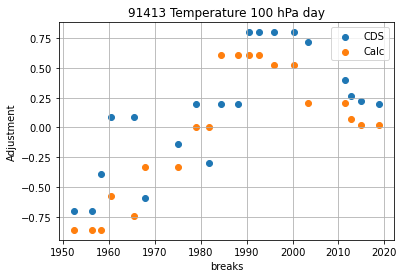

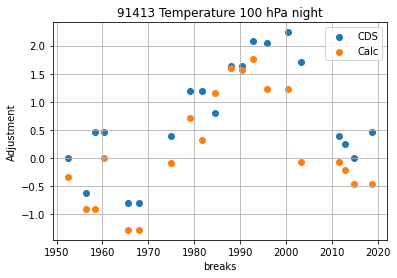

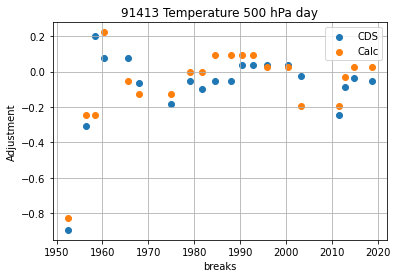

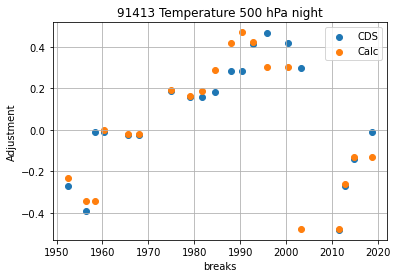

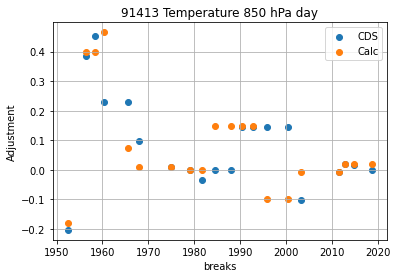

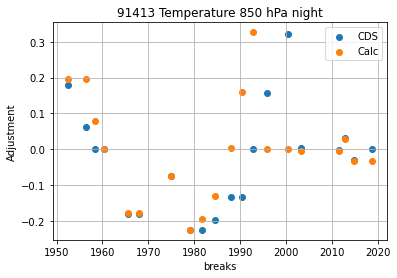

In [6]:
station = '91413'
dates, cd, cn, ad, an = get_adj(station)
plt_adj(dates, cd, ad, 100, station, 'day', save=False)
plt_adj(dates, cn, an, 100, station, 'night', save=False)
plt_adj(dates, cd, ad, 500, station, 'day', save=False)
plt_adj(dates, cn, an, 500, station, 'night', save=False)
plt_adj(dates, cd, ad, 850, station, 'day', save=False)
plt_adj(dates, cn, an, 850, station, 'night', save=False)

2021-04-26 15:49:15,765 INFO Welcome to the CDS
2021-04-26 15:49:15,766 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-04-26 15:49:15,856 INFO Request is completed
2021-04-26 15:49:15,856 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1619430493.9770315-17332-9-5b04736a-b6fb-42b3-9245-1237f01efa80.zip to download.zip (43.3M)
2021-04-26 15:49:19,353 INFO Download rate 12.4M/s  
2021-04-26 15:49:19,501 INFO Reading Profile on slice(None, None, None)


1905-04-04 06:00:00
['20170201', '20100708', '20060629', '20040510', '19941010', '19920322', '19910214', '19890331', '19870115', '19840804', '19791031', '19730428', '19700301', '19680101', '19630209', '19620206', '19600114', '19570119', '19520630']
['1905-04-04 06:00:00', '19520630', '19570119', '19600114', '19620206', '19630209', '19680101', '19700301', '19730428', '19791031', '19840804', '19870115', '19890331', '19910214', '19920322', '19941010', '20040510', '20060629', '20100708', '20170201']


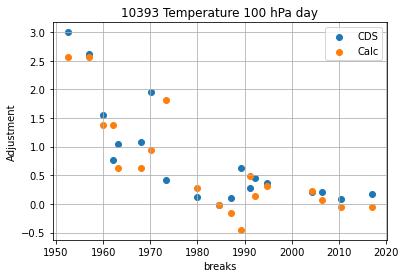

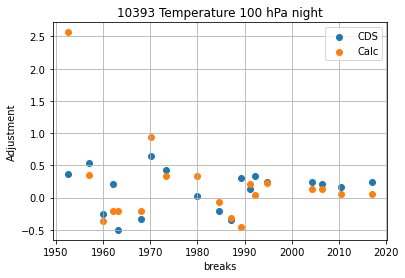

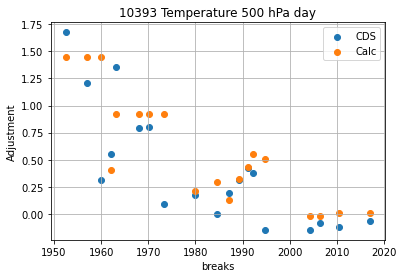

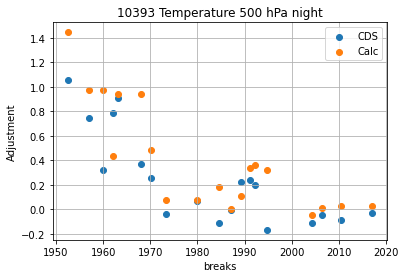

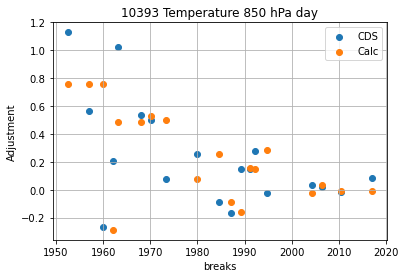

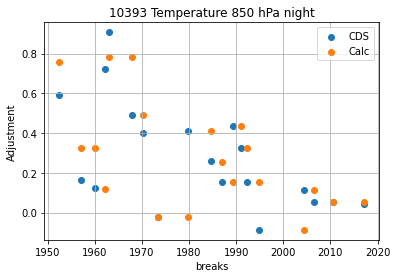

In [7]:
station = '10393'
dates, cd, cn, ad, an = get_adj(station)
plt_adj(dates, cd, ad, 100, station, 'day', save=False)
plt_adj(dates, cn, an, 100, station, 'night', save=False)
plt_adj(dates, cd, ad, 500, station, 'day', save=False)
plt_adj(dates, cn, an, 500, station, 'night', save=False)
plt_adj(dates, cd, ad, 850, station, 'day', save=False)
plt_adj(dates, cn, an, 850, station, 'night', save=False)

2021-04-26 15:49:51,604 INFO Welcome to the CDS
2021-04-26 15:49:51,605 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-04-26 15:49:51,802 INFO Request is completed
2021-04-26 15:49:51,803 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data2/adaptor.comprehensive_upper_air.retrieve-1619418957.6919405-22674-5-9bd54766-c124-49e5-9fde-f2fdec5cb266.zip to download.zip (29M)
2021-04-26 15:49:54,281 INFO Download rate 11.7M/s  
2021-04-26 15:49:54,386 INFO Reading Profile on slice(None, None, None)


1925-01-24 09:22:00
['20181213', '20161212', '20111224', '20030913', '19960809', '19940602', '19920417', '19890821', '19870414', '19840107', '19820106', '19800328', '19760201', '19741119', '19730211', '19690927', '19671230', '19661021', '19650812', '19631106', '19580621', '19560702', '19540226', '19510910', '19500223']
['1925-01-24 09:22:00', '19500223', '19510910', '19540226', '19560702', '19580621', '19631106', '19650812', '19661021', '19671230', '19690927', '19730211', '19741119', '19760201', '19800328', '19820106', '19840107', '19870414', '19890821', '19920417', '19940602', '19960809', '20030913', '20111224', '20161212', '20181213']


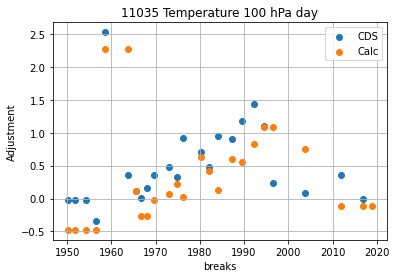

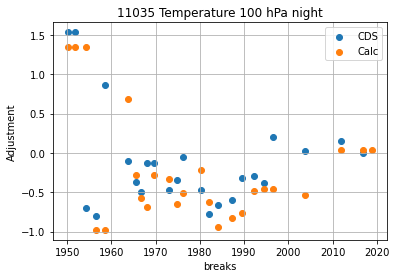

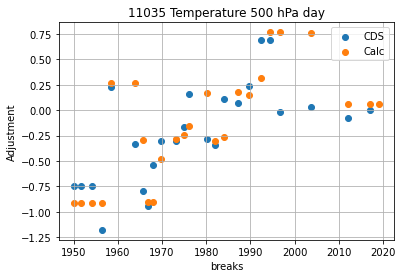

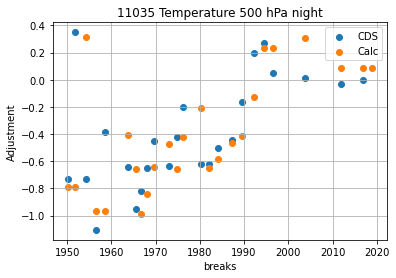

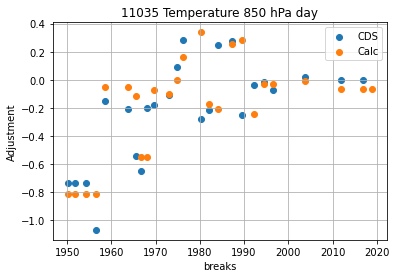

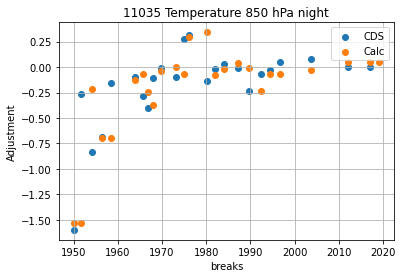

In [8]:
station = '11035'
dates, cd, cn, ad, an = get_adj(station)
plt_adj(dates, cd, ad, 100, station, 'day', save=False)
plt_adj(dates, cn, an, 100, station, 'night', save=False)
plt_adj(dates, cd, ad, 500, station, 'day', save=False)
plt_adj(dates, cn, an, 500, station, 'night', save=False)
plt_adj(dates, cd, ad, 850, station, 'day', save=False)
plt_adj(dates, cn, an, 850, station, 'night', save=False)